## Objective - Use AI algorithm to recognize hand-written digits

#### Import modules, split, and prepare data for modeling

In [2]:
# Import sklearn modules.
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.manifold import TSNE

# Import other modules.
import matplotlib.pyplot as plt
from time import time
import pandas as pd
from math import sqrt
import numpy as np
%matplotlib inline

# Import dataset.
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# NOTE: You can download these files @: https://www.kaggle.com/oddrationale/mnist-in-csv?select=mnist_train.csv

# X is the hand written digits, y is the actual digits (answers).
X_train, y_train = (train.loc[:, '1x1':'28x28'].to_numpy(), train['label'].to_numpy())
X_test, y_test = (test.loc[:, '1x1':'28x28'].to_numpy(), test['label'].to_numpy())

# Removing the mean & scaling to unit variance (generatscaler = preprocessing.StandardScaler()sing.Standarscaler.fit_transform(X_train)form(Xlerlscaler.transform(X_test)car.transform(X_test)

# Create PCA for ditest = pca.transform(X_test)

# X represents the hand written digits which are 28 x 28 in size.
print(f'X_train.shape: {X_train.shape}')    # -> (60,000, 784)

# Y is the actual digits they represent.
print(f'y_train.shape: {y_train.shape}')    # -> (60,000,)

print(f'X_test.shape: {X_test.shape}')    # -> (10,000, 784)
print(f'y_test.shape: {y_test.shape}')    # -> (10,000,)


X_train.shape: (60000, 784)
y_train.shape: (60000,)
X_test.shape: (10000, 784)
y_test.shape: (10000,)


#### Visualize the data using TSNE dimensionality technique

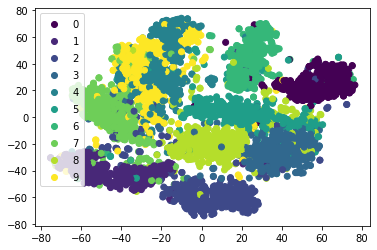

In [3]:
tsne = TSNE()

X_test_trans = tsne.fit_transform(X_test[:5000])

scatter = plt.scatter(X_test_trans[:, 0], X_test_trans[:, 1], c=y_test[:5000])
plt.legend(*scatter.legend_elements())

# Data is formed in clusters and looks to be non-linear.


(7000, 784)
(7000,)
(784,)
True


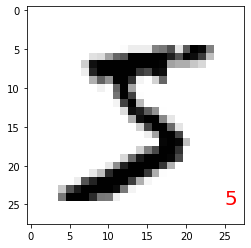

In [4]:
# Shorten amount of samples.
data = np.concatenate((X_train[:6000], X_test[:1000]))
target = np.concatenate((y_train[:6000], y_test[:1000]))

print(data.shape)    # -> (7000, 784)
print(target.shape)    # -> (7000,)

print(data[0].shape)    # -> (784,)

sample = data[0].reshape((28, 28))

plt.imshow(sample, cmap='binary')
plt.text(25, 25, target[0], fontsize=20, color='red')

# Checking one more time if the concatenation was correct:
print(target[6000] == y_test[0])    # -> True

#### Do more data analysis (check for patterns in data)

In [5]:
# Check % of data that's 0.
print(np.sum(X_train == 0)/(60000*784))    # -> 80%
print(np.sum(X_train != 0)/(60000*784))    # -> 20%

# Check for null values.
print(np.isnan(np.sum(data)))    # -> False


0.8087977040816327
0.19120229591836735
False


#### Apply Pipeline model to cross validate system

In [6]:
# Use SVD for decomposition with pipeline.
pipe = Pipeline([
    ('svd', TruncatedSVD(n_components=149)),
    ('svm', SVC())
])

# NOTE: SVDs are good for dimensionality reduction when data has a lot of zeros.

cross_validate_args = {
    'cv': 5,
    'n_jobs': -1,
    'verbose': 100,
    'return_train_score': True,
    'return_estimator': True
}

svm = cross_validate(pipe, data, target, **cross_validate_args)

svm_scores = {
    'train': np.average(svm['train_score']),
    'test': np.average(svm['test_score'])
}

print('Train Score: {}'.format(svm_scores['train']))
print('Test Score: {}'.format(svm_scores['test']))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   21.7s remaining:   32.7s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   21.8s remaining:   14.5s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.0s finished
Train Score: 0.9805714285714284
Test Score: 0.9501428571428571


#### Check how SVD affected the data

In [7]:
svd = pipe.named_steps['svd']

X_train_trans = svd.fit_transform(X_train)

print(X_train_trans.shape)    # -> (60000, 149)

zeros_before = np.sum(X_train==0)/(60000*784)
zeros_after = np.sum(X_train_trans==0)/(60000*149)

nonzeros_before = np.sum(X_train!=0)/(60000*784)
nonzeros_after = np.sum(X_train_trans!=0)/(60000*149)

print(f'% of Zeros in Data: Before SVD: {zeros_before:.2f}, After SVD: {zeros_after}')
print(f'% of Non Zero in Data: Before SVD: {nonzeros_before:.2f}, After SVD: {nonzeros_after}')

(60000, 149)
% of Zeros in Data: Before SVD: 0.81, After SVD: 0.0
% of Non Zero in Data: Before SVD: 0.19, After SVD: 1.0


#### Visualize the results of the predictions

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.3s remaining:   18.6s
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:   12.4s remaining:    8.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   12.6s finished


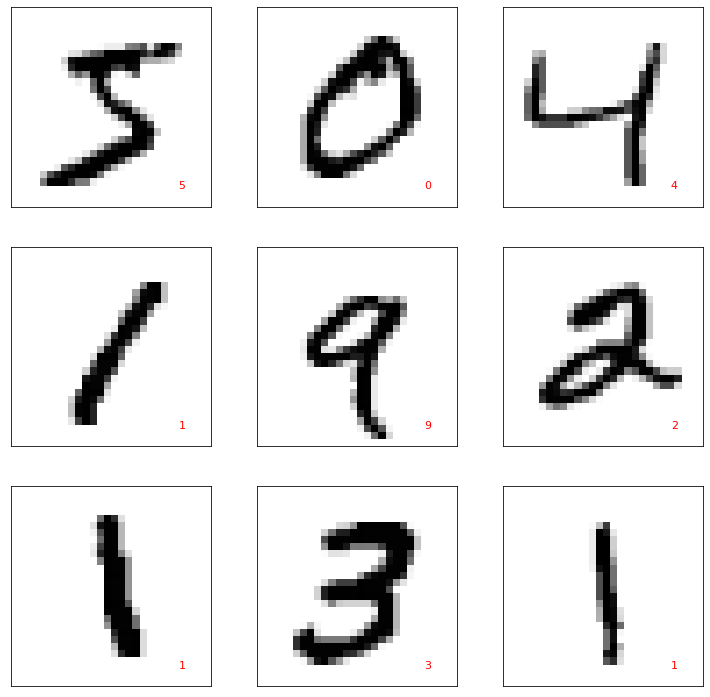

In [9]:
# Create cross validation arguments for predictions.
cross_validate_args_pred = {
    'cv': 5,
    'n_jobs': -1,
    'verbose': 100
}

predictions = cross_val_predict(pipe, data, target, **cross_validate_args_pred)[:9]

# Making data 3D so that imshow() can read data correctly as an image.

# NOTE: The reshaping of the array is to make the sample the shape of a sample.

data_imgs = data[:9].reshape(9, 28, 28)

fig, axs = plt.subplots(3, 3, subplot_kw={'yticks': (), 'xticks': ()}, figsize=(12.5, 12.5))

axs = [ax for ax in axs.ravel()]

for ax, prediction, data_img in zip(axs, predictions, data_imgs):
    ax.imshow(data_img, cmap='binary')
    ax.text(23, 25, prediction, fontsize=11, color='red')
